# Семинар 3. Определение максимально правдоподобных распределений для данных

Для того, чтобы корректно применять статистические тесты, а также выуживать из данных максимальное количество информации, которая в них хранится, необходимо точно понимать, по какому закону эти данные распределены.

На этом семинаре мы разберём, как корректно понять, что именно за распределение в данных мы наблюдаем. Для примера мы загрузим набор данных из ресурса <a href="https://jhubiostatistics.shinyapps.io">ReCount2</a> (в целом это полезный ресурс в случае, если вам необходимо загрузить из открытых источников именно RNA-Seq count data).

## Домашнее задание

Определите максимально правдоподобное распределение для наших данных. Попробуйте это сделать на случайной выборке из экспрессий 30 других генов. Согласованный ли получился результат?

In [353]:
df = pd.read_csv("LUAD_counts.tsv", sep="\t")
df.index = [gene.split(".")[0] for gene in df.gene_name]
del df["gene_name"]
df = df.T

filtered_df = df.loc[:, (df != 0).all()] # фильтруем для расчёта MLE и в, частности, lognorm
genes_expr = df[np.random.choice(filtered_df.columns, 30)]

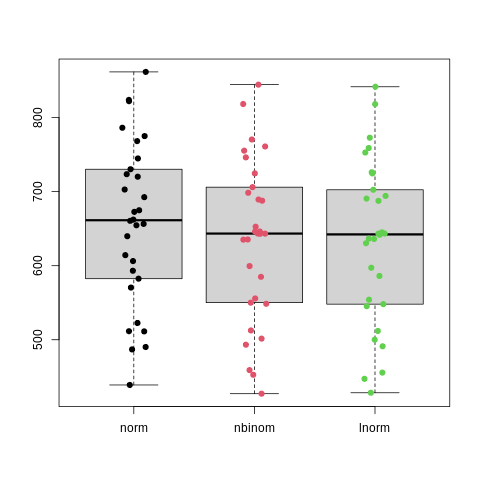

In [354]:
%%R -i genes_expr
library(ggplot2)


data <- as.data.frame(genes_expr) # переводим в вектор, ибо -i делает list
#fit.norm <- fitdist(data, "norm") # как наши точки фитятся в нормальное распределение
#summary(fit.norm)$aic

fit_norm <- c()
fit_nb <- c()
fit_lnorm <- c()

for (gene_name in names(data)){
    fit_norm <- c(fit_norm, summary(fitdist(data[[gene_name]], "norm"))$aic)
    fit_nb <-c(fit_nb, summary(fitdist(data[[gene_name]], "nbinom"))$aic)
    fit_lnorm <- c(fit_lnorm,summary(fitdist(data[[gene_name]], "lnorm"))$aic)
}

data <- data.frame(fit_norm, fit_nb, fit_lnorm)
colnames(data) = c("norm","nbinom", "lnorm")

boxplot(data)
stripchart(data, vertical = TRUE, method = "jitter", pch=19,add = TRUE, col = 1:3)

После около десятка экспериментов и построенных box-plots в большей части экспериментов каунты наших генов лучше фитятся lognorm-распределением, нежели negative binomial. <br> <br>

Скачайте датасет <code>1M8-86VecaYPERovPk4JKhT2lLa4PfJxi</code> из статьи <a href="https://bmcgenomics.biomedcentral.com/articles/10.1186/1471-2164-13-304#Sec8">Oberg et al., 2012</a>. Внимательно прочитайте статью и изучите дизайн эксперимента &mdash; какие реплики в статье называют техническими, а какие &mdash; биологическими? Правда ли в технических репликах наблюдается распределение Пуассона?

In [356]:
!gdown 1M8-86VecaYPERovPk4JKhT2lLa4PfJxi

Downloading...
From: https://drive.google.com/uc?id=1M8-86VecaYPERovPk4JKhT2lLa4PfJxi
To: /home/silenos/Programs/Bioinformatics/Transcriptomics/03_Определение_распределений/GSE29022_gene_counts.txt
100%|██████████████████████████████████████| 2.76M/2.76M [00:00<00:00, 6.16MB/s]


In [57]:
def plot_mean_var(df):

    means = np.mean(df.values, axis=0)
    vars = np.var(df.values, axis=0)

    means = means[vars > 0]
    vars = vars[vars > 0]

    means = np.log10(means)
    vars = np.log10(vars)

    sns.set_style("ticks")
    fig, ax = plt.subplots(figsize=(4, 4), dpi=100)

    ax.scatter(means, vars)
    ax.plot([-3, 12], [-3, 12], color="red") # линия при E = VAR
    #ax.set_xlim(-3, 12)
    #ax.set_ylim(-3, 12)
    ax.grid(alpha=0.3)

    ax.set_xlabel("log$_{10}$(Mean)")
    ax.set_ylabel("log$_{10}$(Variance)");

In [58]:
df = pd.read_csv("GSE29022_gene_counts.txt", delimiter='\t').T
df = df.loc[:, (df != 0).all()] 

df.reset_index(inplace=True)
df[['sample', 'flowcell', 'lane']] = df['index'].apply(lambda x: pd.Series(str(x).split(".")))
df.drop(columns='index', inplace=True)
df = df[list(df.columns[-3:])+list(df.columns[:-3])]

In [43]:
df.head(10)

,sample,flowcell,lane,0,1,2,3,4,5,6,...,17343,17344,17345,17346,17347,17348,17349,17350,17351,17352
0,sample4019,flowcell30WPLAAXX,lane5,785,527,3,117,30,14,1,...,103,0,6,49,0,20,165,0,25,220
1,sample4019,flowcell30WPLAAXX,lane6,761,501,2,129,30,11,3,...,102,0,9,50,0,15,196,0,30,218
2,sample6045,flowcell30WP5AAXX,lane1,794,466,3,80,19,0,6,...,181,0,16,53,0,8,214,0,32,169
3,sample6045,flowcell30WP5AAXX,lane2,888,581,1,71,34,3,6,...,219,0,26,59,0,16,205,0,18,162
4,sample2550,flowcell305TMAAXX,lane3,873,259,1,61,16,8,0,...,118,0,11,17,0,10,115,0,38,169
5,sample2550,flowcell305TMAAXX,lane4,836,259,1,52,21,4,4,...,135,0,17,13,0,6,125,1,37,161
6,sample1286,flowcell305TMAAXX,lane7,930,321,2,74,15,10,0,...,114,0,6,37,1,10,120,0,20,185
7,sample1286,flowcell305TMAAXX,lane8,874,361,2,70,24,7,1,...,110,0,7,24,0,15,137,0,20,174
8,sample6113,flowcell30WFYAAXX,lane3,1053,381,2,55,16,9,4,...,168,0,32,44,0,19,168,0,52,283
9,sample6113,flowcell30WFYAAXX,lane4,1050,391,3,74,21,6,2,...,159,0,46,34,0,17,180,0,46,265


In [36]:
vars = df.groupby(by=['sample', 'flowcell']).var().values
means = df.groupby(by=['sample', 'flowcell']).mean().values

means = means[vars > 0] # vars > 0 (для логарифмирования)
vars = vars[vars > 0]

means = np.log10(means)
vars = np.log10(vars)

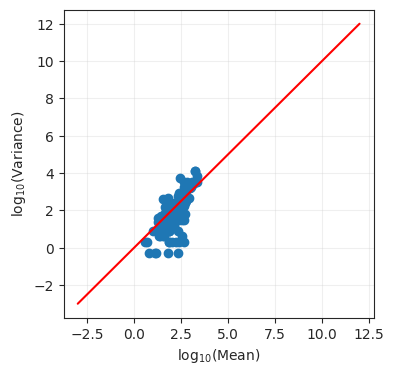

In [37]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(4, 4), dpi=100)

ax.scatter(means[:100], vars[:100])
ax.plot([-3, 12], [-3, 12], color="red") # линия при E = VAR
#ax.set_xlim(-3, 12)
#ax.set_ylim(-3, 12)
ax.grid(alpha=0.3)

ax.set_xlabel("log$_{10}$(Mean)")
ax.set_ylabel("log$_{10}$(Variance)");

На графике mean-var явление овердисперсии не наблюдается, что характерно для распределения Пуассона

Проделайте подобную процедуру с каунтами генов, которые вы получили в результате анализа <a href="https://www.nature.com/articles/s41598-018-23226-4">статьи</a> со сравнением методов подготовки библиотек для scRNA-Seq (`1Mh2T7YyWG9LPQsuNGy_IdYhbbzUgZUek`). Разберитесь, что в случае этой работы называют технической репликой. Актуально ли распределение Пуассона в случае таких технических реплик?

In [2]:
!gdown 1Mh2T7YyWG9LPQsuNGy_IdYhbbzUgZUek

Downloading...
From: https://drive.google.com/uc?id=1Mh2T7YyWG9LPQsuNGy_IdYhbbzUgZUek
To: /home/silenos/Programs/Bioinformatics/Transcriptomics/03_Определение_распределений/polyA_total_counts.tsv
100%|██████████████████████████████████████| 1.87M/1.87M [00:01<00:00, 1.55MB/s]


In [64]:
df = pd.read_csv("polyA_total_counts.tsv", sep='\t')
df.rename(columns={"Unnamed: 0":"gene_name"}, inplace=True)
df.index = df.gene_name
del df['gene_name']
df = df.T

In [68]:
df.head

gene_name,MAFIP,KIR3DL2,KIR3DL2,KIR3DL2,KIR3DL2,KIR3DL2,KIR3DL2,KIR3DL2,KIR3DL2,KIR3DL2,...,PRY,BPY2,DAZ1,DAZ2,CDY1B,BPY2B,DAZ3,DAZ4,BPY2C,CDY1
colon_polyA_3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,148,0,0,0,0
colon_polyA_4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
colon_polyA_1,0,0,0,0,0,0,0,0,0,0,...,0,26,0,0,0,0,0,0,63,0
colon_polyA_2,0,0,0,0,0,0,0,0,0,0,...,0,0,74,0,0,0,0,0,0,0
colon_total_3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
colon_total_4,0,0,0,0,0,0,0,0,0,0,...,117,0,0,0,0,0,0,0,0,0
colon_total_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
colon_total_2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pbmc_polyA_3,0,0,0,0,0,0,0,0,0,0,...,1011,76,560,158,0,34,107,46,279,527
pbmc_polyA_4,0,0,0,0,0,0,0,0,0,0,...,934,76,736,207,0,142,180,206,145,301


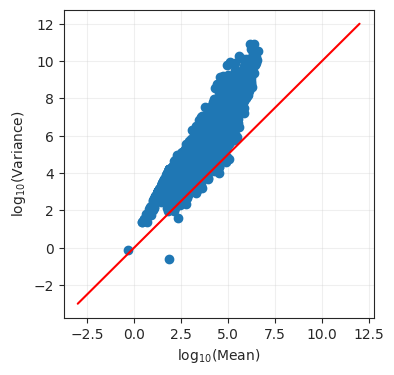

In [75]:
# blood poly
plot_mean_var(df[df.index.str.contains('pbmc.*poly')])

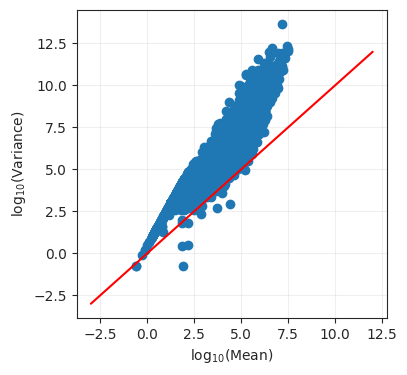

In [76]:
#blood total
plot_mean_var(df[df.index.str.contains('pbmc.*total')])

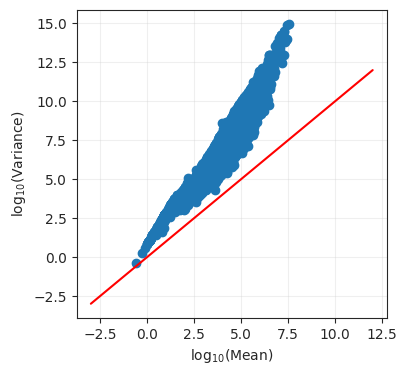

In [65]:
# colon
plot_mean_var(df[df.index.str.contains('colon')])

График рассеяния среднего-дисперсии показывает, что технические реплики (употребленные в своём значении согласно статье) не принадлежат Пуасонновскому распределению. Причина такой повышенной вариации каунтов - создание реплик ПЕРЕД процедурами молекулярного характера и секвенированием ( когда в предыдущей статье технические реплики создавались ПОСЛЕ молекулярных процедур, помещаясь непосредственно в соседние дорожки проточной ячейки и секвенатор).